In [1]:
import os
import re
import pandas as pd
import nilearn as nl
import numpy as np
import seaborn as sns
from nilearn.input_data import NiftiMasker
from nilearn.image.image import mean_img
from nilearn import plotting, image
from nilearn.plotting import view_img
import warnings
warnings.filterwarnings("ignore")
from nilearn.image import math_img
import time
import multiprocessing
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
project_dir='/ZPOOL/data/projects/rf1-mbme-pilot'
subs=pd.read_csv('../derivatives/exclusions.csv')
print("We collected and downloaded data from %s subjects"%(len(subs['sub'].unique())))
GoodSubs=subs.groupby(by='sub').sum()
#print(GoodSubs.columns)
GoodSubs=GoodSubs[
    (GoodSubs['FD_exclusion']<=2)&(
        GoodSubs['ABS_exclusion']<=1)&(
        GoodSubs['Beh_TrialExclusion']<=2)].reset_index()
#subs=subs[subs['sub'].isin(GoodSubs['sub'].values)].sort_values(by='sub')
subs.reset_index(inplace=True)

HC=[]
for index, row in subs.iterrows():
    if row['acq'] in ['mb1me4','mb3me4','mb6me4']:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_echo-1_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    else:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    #print(fname)
    f = open(fname)
    data = json.load(f)
    HC.append(data['ReceiveCoilName'])
    f.close()
subs['HeadCoil']=HC
subs['MB'] =  [int(re.search('mb(.*)me',str(x)).group(1)) for x in subs['acq']]
subs['ME'] =  [int(re.search('me(.*)',str(x)).group(1)) for x in subs['acq']]

print(" There are %s number of subjects who passed the exclusion criteria."%(len(subs['sub'].unique())))
print(" %s Were collected using a 64 channel headcoil and %s with a 20 channel headcoil"%(len(subs[subs['HeadCoil']=='HeadNeck_64']['sub'].unique()),
                                                                                          len(subs[subs['HeadCoil']=='HeadNeck_20']['sub'].unique())))
  

We collected and downloaded data from 43 subjects
 There are 43 number of subjects who passed the exclusion criteria.
 24 Were collected using a 64 channel headcoil and 19 with a 20 channel headcoil


# Count Subjects with full L1 output

In [3]:
act=[]
ppi=[]
L2ppi=[]
for index,row in subs.iterrows():
    sub=row['sub']
    acq=row['acq']
    act.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/tstat11.nii.gz'%(sub,acq)))
    ppi.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/tstat11.nii.gz'%(sub,acq)))
    L2ppi.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L2_task-sharedreward_model-1_type-ppi_seed-VS_thr5_sm-4.gfeat/cope10.feat/stats/cope1.nii.gz'%(sub)))

subs['L1act']=act
subs['L1ppi']=ppi
subs['L2ppi']=L2ppi
#display(subs)
subs[subs['L2ppi']==False].head()

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,MB,ME,L1act,L1ppi,L2ppi
0,0,sub-10154,mb1me1,0,1.133680,0.124930,False,False,False,HeadNeck_64,1,1,False,False,False
1,1,sub-10154,mb3me4,1,0.332495,0.089944,False,False,False,HeadNeck_64,3,4,False,False,False
2,2,sub-10154,mb3me1,1,1.306430,0.134964,False,False,False,HeadNeck_64,3,1,False,False,False
3,3,sub-10154,mb6me4,0,1.075030,0.076886,False,False,False,HeadNeck_64,6,4,False,False,False
4,4,sub-10154,mb1me4,0,0.948951,0.154912,False,False,False,HeadNeck_64,1,4,False,False,False


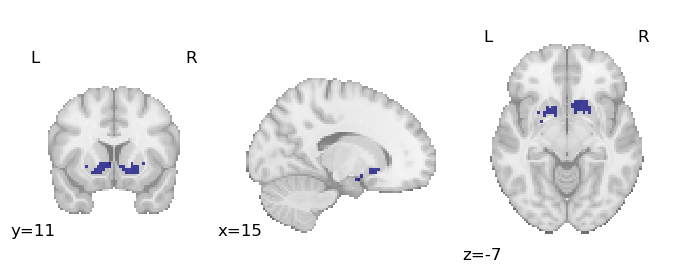

In [4]:
r_vs='../masks/fROI-RVS_cname-RewVsPun_zstat-1.nii.gz'
l_vs='../masks/fROI-LVS_cname-RewVsPun_zstat-1.nii.gz'
F_VS=math_img('img1+img2',img1=r_vs,img2=l_vs)
plotting.plot_roi(F_VS,draw_cross=False)
plt.savefig("../derivatives/figures/assets/mask_VS-func.svg")
plt.show()

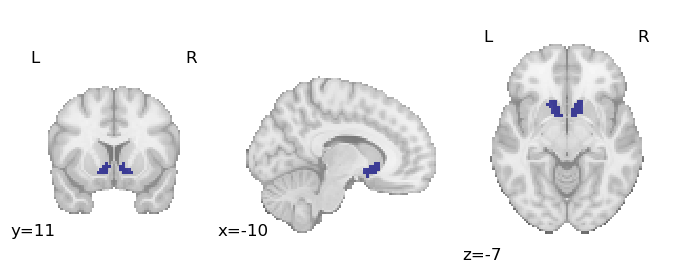

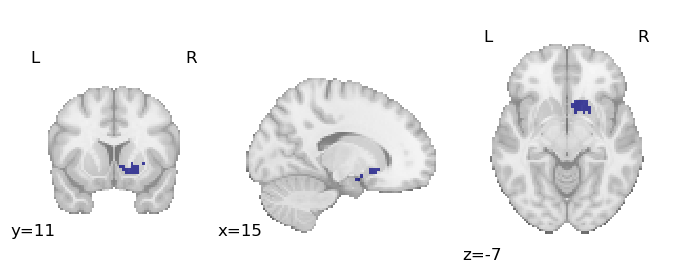

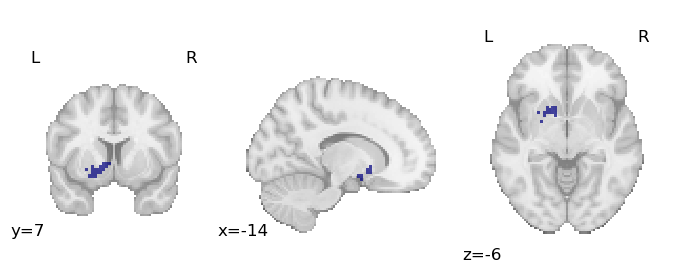

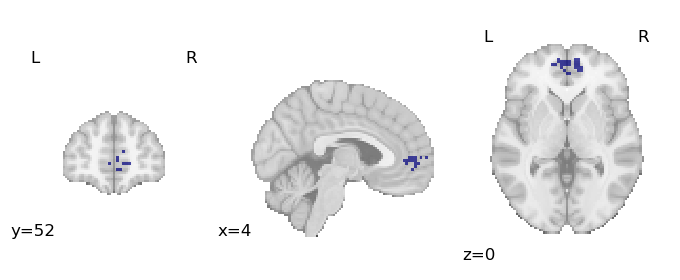

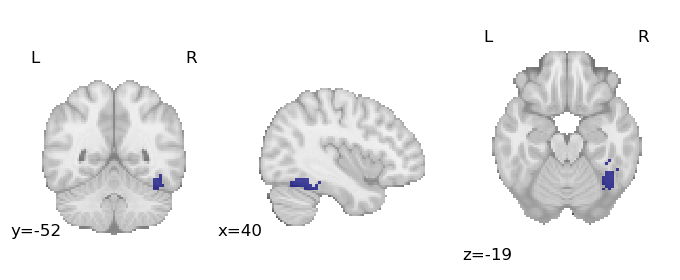

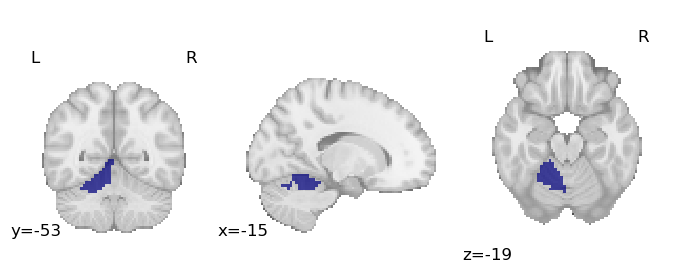

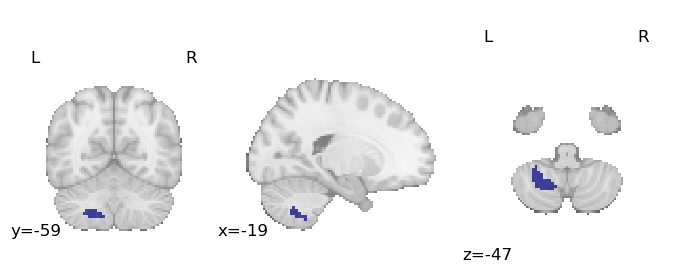

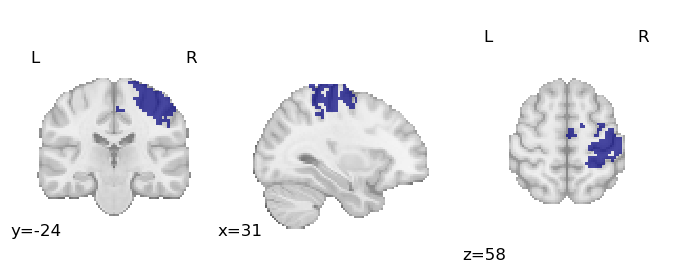

In [5]:
from nilearn import  image
#Striatum Mask
if 1==1:
    VS_mask='../masks/ROI-VS_cname-prereg.nii.gz'
    rstr_mask='../masks/fROI-RVS_cname-RewVsPun_zstat-1.nii.gz'
    lstr_mask='../masks/fROI-LVS_cname-RewVsPun_zstat-1.nii.gz'
    pfc_mask='../masks/fROI-vmPFC_cname-RewVsPun_zstat-1.nii.gz'
    FFA_mask='../masks/fROI-FFA_cname-StrVsComp_zstat-1.nii.gz'#'../masks/FFA_voxel-thresh-mask.nii.gz'
    sCerb_mask='../masks/fROI-sCerb_cname-LeftVsRight_zstat-1.nii.gz'#'../masks/right-cerb_voxel-thresh.nii.gz'
    iCerb_mask='../masks/fROI-iCerb_cname-LeftVsRight_zstat-1.nii.gz'#'../masks/left-cerb_voxel-thresh.nii.gz'
    motor_mask='../masks/fROI-Motor_cname-LeftVsRight_zstat-1.nii.gz'#'../masks/right-motor_voxel-thresh.nii.gz'
    mask_list=[VS_mask,rstr_mask,lstr_mask,pfc_mask,FFA_mask,sCerb_mask,iCerb_mask,motor_mask]
    
    for mask in mask_list:
        str_mask=NiftiMasker(mask_img=mask)
        #mask_name=re.search('ROI-(.*)_cname',mask).group(1)
        #print(mask_name)
        mask_name='unknown'
        plotting.plot_roi(mask,draw_cross=False)
        plt.savefig("../derivatives/figures/assets/mask_%s.svg"%(mask_name))
        plt.show()
mask_list=[F_VS,VS_mask,rstr_mask,lstr_mask,pfc_mask,FFA_mask,sCerb_mask,iCerb_mask,motor_mask]


# VS- Reward Activiation

In [6]:
#masker= NiftiMasker(mask_img=VS_mask)
masker= NiftiMasker(mask_img=F_VS)
                   
copes=[]
tstats=[]
varcopes=[]

tedana_tstats=[]
tedana_copes=[]
GO=1
if os.path.exists('tstat_res.csv'):
    subs=read_csv('tstat_res.csv')
    if 'VS_Reward_tstats' in subs.columns:
        GO=0
if GO:
    for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
        sub=row['sub']
        aqc=row['acq']
        cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/cope13.nii.gz'%(sub,aqc)
        tstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/tstat13.nii.gz'%(sub,aqc)
        varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/varcope13.nii.gz'%(sub,aqc)

        tedana_cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-tedana.feat/stats/cope13.nii.gz'%(sub,aqc)
        tedana_tstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-tedana.feat/stats/tstat13.nii.gz'%(sub,aqc)
        tedana_varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-tedana.feat/stats/varcope13.nii.gz'%(sub,aqc)

        if os.path.exists(cope):
            #Extracting VS Reward cope,tstat, and varcope
            x=masker.fit_transform(cope)
            copes.append(np.mean(x.flatten()))

            x=masker.fit_transform(tstat)
            tstats.append(np.mean(x.flatten()))

            x=masker.fit_transform(varcope)
            varcopes.append(np.mean(x.flatten()))
        else:
            copes.append(np.nan)
            tstats.append(np.nan)
            varcopes.append(np.nan)
        if os.path.exists(tedana_cope):
            #Extracting VS Reward cope,tstat, and varcope
            x=masker.fit_transform(tedana_cope)
            tedana_copes.append(np.mean(x.flatten()))

            x=masker.fit_transform(tstat)
            tedana_tstats.append(np.mean(x.flatten()))

        else:
            tedana_copes.append(np.nan)
            tedana_tstats.append(np.nan)

    subs = subs.assign(VS_Reward_cope=copes,
                   VS_Reward_tstats=tstats,
                   VS_Reward_varcope=varcopes,
                      VS_Reward_cope_tedana=tedana_copes,
                      VS_Reward_tstat_tedana=tedana_tstats)
subs.to_csv('tstat_res.csv',index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [04:39<00:00,  1.09s/it]


In [7]:
mod_df=subs
mod_df
subs.to_csv('tstat_res.csv',index=False)

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,MB,ME,L1act,L1ppi,L2ppi,VS_Reward_cope,VS_Reward_tstats,VS_Reward_varcope,VS_Reward_cope_tedana,VS_Reward_tstat_tedana
0,0,sub-10154,mb1me1,0,1.133680,0.124930,False,False,False,HeadNeck_64,1,1,False,False,False,169.340164,0.259695,311350.500000,NaN,NaN
1,1,sub-10154,mb3me4,1,0.332495,0.089944,False,False,False,HeadNeck_64,3,4,False,False,False,96.571205,0.373045,92731.000000,271.749420,0.373045
2,2,sub-10154,mb3me1,1,1.306430,0.134964,False,False,False,HeadNeck_64,3,1,False,False,False,148.511169,0.516198,92801.890625,NaN,NaN
3,3,sub-10154,mb6me4,0,1.075030,0.076886,False,False,False,HeadNeck_64,6,4,False,False,False,209.813400,0.750894,81903.382812,136.601395,0.750894
4,4,sub-10154,mb1me4,0,0.948951,0.154912,False,False,False,HeadNeck_64,1,4,False,False,False,89.110626,0.130900,447060.468750,-101.577118,0.130900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,sub-10321,mb3me4,1,0.495774,0.077673,False,False,False,HeadNeck_20,3,4,False,False,False,31.184574,0.083315,364276.250000,3.054617,0.083315
252,252,sub-10321,mb3me1,0,0.635318,0.120255,False,False,False,HeadNeck_20,3,1,False,False,False,424.595245,0.820656,307411.562500,NaN,NaN
253,253,sub-10321,mb6me4,1,0.817520,0.086703,False,False,False,HeadNeck_20,6,4,False,False,False,302.928436,0.581565,306335.656250,405.740692,0.581565
254,254,sub-10321,mb1me4,4,0.267242,0.073738,False,False,False,HeadNeck_20,1,4,False,False,False,33.700668,0.067918,771754.062500,36.779118,0.067918


# Display Reward Activation by Acquisition

144
HeadNeck_64
t-stat


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       VS_Reward_tstats   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.478
Date:                Wed, 02 Aug 2023   Prob (F-statistic):            0.00969
Time:                        15:27:36   Log-Likelihood:                -100.68
No. Observations:                 143   AIC:                             211.4
Df Residuals:                     138   BIC:                             226.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3594      0.178      2.017      0.046       0.007       0.712
MB             0.0727      0.040      1.829      0.070      -0.006       0.151
ME             0.0357      0.053      0.670      0.504      -0.070       0.141
MB:ME         -0.0162      0.014     -1.196      0.234      -0.043       0.011
FD_mean       -1.2444      0.435     -2.864      0.005      -2.104      -0.385
==============================================================================
Omnibus:                        7.588   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                8.129
Skew:                           0.403   Prob(JB):                       0.0172
Kurtosis:                       3.845   Cond. No.                         131.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

beta


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         VS_Reward_cope   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     2.883
Date:                Wed, 02 Aug 2023   Prob (F-statistic):             0.0249
Time:                        15:27:36   Log-Likelihood:                -940.54
No. Observations:                 143   AIC:                             1891.
Df Residuals:                     138   BIC:                             1906.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    163.3625     63.335      2.579      0.011      38.129     288.596
MB             7.6855     14.132      0.544      0.587     -20.258      35.629
ME            19.3377     18.917      1.022      0.308     -18.066      56.742
MB:ME         -5.2627      4.810     -1.094      0.276     -14.773       4.247
FD_mean     -484.4588    154.426     -3.137      0.002    -789.806    -179.112
==============================================================================
Omnibus:                        5.081   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                4.860
Skew:                           0.324   Prob(JB):                       0.0880
Kurtosis:                       3.630   Cond. No.                         131.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


112
HeadNeck_20
t-stat


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       VS_Reward_tstats   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     2.643
Date:                Wed, 02 Aug 2023   Prob (F-statistic):             0.0380
Time:                        15:27:36   Log-Likelihood:                -57.887
No. Observations:                 104   AIC:                             125.8
Df Residuals:                      99   BIC:                             139.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0197      0.207      0.095      0.924      -0.391       0.431
MB             0.1111      0.040      2.751      0.007       0.031       0.191
ME             0.0666      0.056      1.194      0.235      -0.044       0.177
MB:ME         -0.0337      0.014     -2.422      0.017      -0.061      -0.006
FD_mean        0.1991      0.706      0.282      0.779      -1.202       1.600
==============================================================================
Omnibus:                        1.021   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.600   Jarque-Bera (JB):                0.647
Skew:                          -0.177   Prob(JB):                        0.723
Kurtosis:                       3.157   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

beta


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         VS_Reward_cope   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.8450
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.500
Time:                        15:27:36   Log-Likelihood:                -681.27
No. Observations:                 104   AIC:                             1373.
Df Residuals:                      99   BIC:                             1386.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     61.5943     83.084      0.741      0.460    -103.262     226.451
MB            24.6750     16.200      1.523      0.131      -7.470      56.820
ME            21.9662     22.377      0.982      0.329     -22.435      66.368
MB:ME         -9.0660      5.579     -1.625      0.107     -20.137       2.005
FD_mean      -53.8564    283.210     -0.190      0.850    -615.807     508.094
==============================================================================
Omnibus:                        4.075   Durbin-Watson:                   2.220
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                3.410
Skew:                          -0.388   Prob(JB):                        0.182
Kurtosis:                       3.429   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Results for tstatistics


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       VS_Reward_tstats   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     2.774
Date:                Wed, 02 Aug 2023   Prob (F-statistic):            0.00598
Time:                        15:27:36   Log-Likelihood:                -161.26
No. Observations:                 247   AIC:                             340.5
Df Residuals:                     238   BIC:                             372.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.2335      0.186      1.256      0.210      -0.133       0.600
HeadCoil[T.HeadNeck_64]           0.0623      0.227      0.274      0.784      -0.386       0.510
MB                                0.1012      0.044      2.311      0.022       0.015       0.187
MB:HeadCoil[T.HeadNeck_64]       -0.0258      0.058     -0.447      0.655      -0.139       0.088
ME                                0.0458      0.060      0.766      0.444      -0.072       0.163
ME:HeadCoil[T.HeadNeck_64]       -0.0079      0.078     -0.101      0.920      -0.162       0.146
MB:ME                            -0.0308      0.015     -2.035      0.043      -0.061      -0.001
MB:ME:HeadCoil[T.HeadNeck_64]     0.0143      0.020      0.719      0.473      -0.025       0.053
FD_mean                          -0.9235      0.364     -2.534      0.012      -1.641      -0.206
==============================================================================
Omnibus:                        5.134   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                5.856
Skew:                           0.184   Prob(JB):                       0.0535
Kurtosis:                       3.659   Cond. No.                         180.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

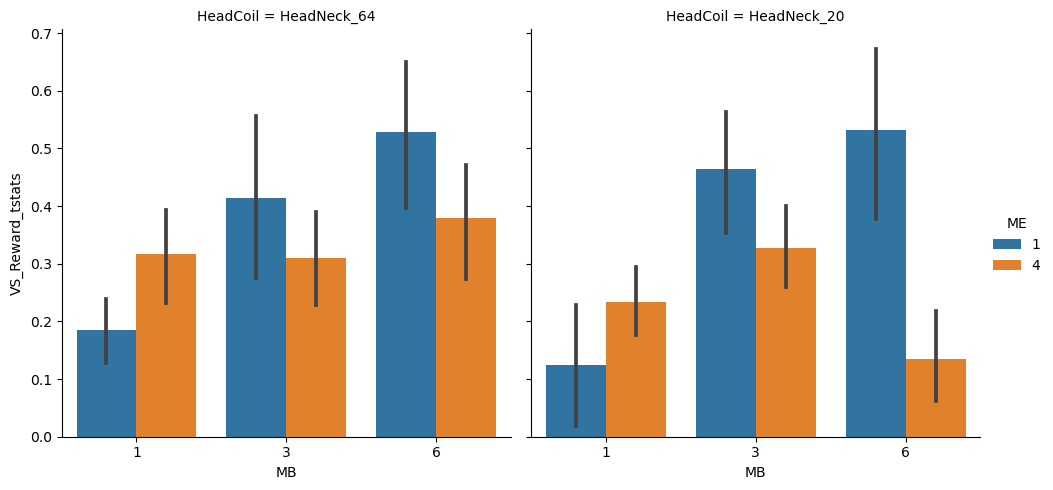

Results for Cope


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         VS_Reward_cope   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.653
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.111
Time:                        15:27:37   Log-Likelihood:                -1622.8
No. Observations:                 247   AIC:                             3264.
Df Residuals:                     238   BIC:                             3295.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       125.3691     69.021      1.816      0.071     -10.601     261.339
HeadCoil[T.HeadNeck_64]          19.0119     84.469      0.225      0.822    -147.391     185.415
MB                               21.7243     16.262      1.336      0.183     -10.311      53.760
MB:HeadCoil[T.HeadNeck_64]      -13.2291     21.412     -0.618      0.537     -55.410      28.952
ME                               15.7380     22.179      0.710      0.479     -27.954      59.430
ME:HeadCoil[T.HeadNeck_64]        4.2666     28.985      0.147      0.883     -52.832      61.366
MB:ME                            -8.1915      5.614     -1.459      0.146     -19.252       2.868
MB:ME:HeadCoil[T.HeadNeck_64]     2.8327      7.366      0.385      0.701     -11.677      17.343
FD_mean                        -388.7286    135.298     -2.873      0.004    -655.262    -122.195
==============================================================================
Omnibus:                        2.388   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.303   Jarque-Bera (JB):                2.406
Skew:                          -0.014   Prob(JB):                        0.300
Kurtosis:                       3.483   Cond. No.                         180.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

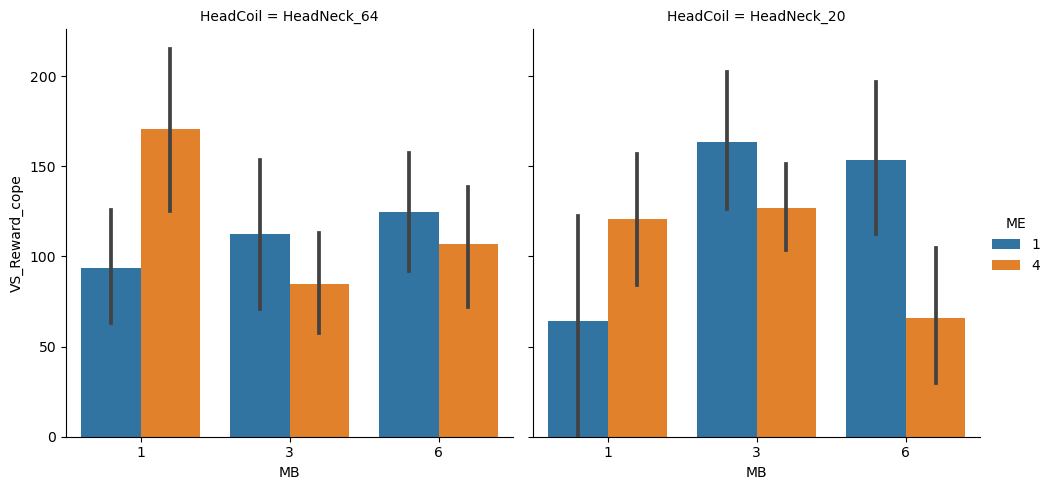

In [8]:
import statsmodels.formula.api as smf
plt_df=subs


for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(len(mod_df))
    print(HC)
    print("t-stat")
    res=smf.ols('VS_Reward_tstats ~ MB * ME+FD_mean',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.ols('VS_Reward_cope ~ MB * ME+FD_mean',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for tstatistics")
res=smf.ols('VS_Reward_tstats ~ MB * ME * HeadCoil+FD_mean',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())

sns.catplot(x='MB',y='VS_Reward_tstats',hue='ME',data=plt_df,kind='bar',ci=68,
            order=[1,3,6],col='HeadCoil')

plt.savefig("../derivatives/figures/assets/Reward_VS-act_tstat.svg")
plt.show()

print("Results for Cope")
res=smf.ols('VS_Reward_cope ~ MB * ME * HeadCoil+FD_mean',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='VS_Reward_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])
plt.savefig("../derivatives/figures/assets/Reward_VS-act_cope.svg")

plt.show()

# print("Results for VarCope")
# res=smf.ols('VS_Reward_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='VS_Reward_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
#plt.savefig("../derivatives/figures/assets/Reward_VS-act_varcope.svg")
#plt.show()

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,MB,ME,L1act,L1ppi,L2ppi,VS_Reward_cope,VS_Reward_tstats,VS_Reward_varcope,VS_Reward_cope_tedana,VS_Reward_tstat_tedana
0,0,sub-10154,mb1me1,0,1.133680,0.124930,False,False,False,HeadNeck_64,1,1,False,False,False,169.340164,0.259695,311350.500000,NaN,NaN
1,1,sub-10154,mb3me4,1,0.332495,0.089944,False,False,False,HeadNeck_64,3,4,False,False,False,96.571205,0.373045,92731.000000,271.749420,0.373045
2,2,sub-10154,mb3me1,1,1.306430,0.134964,False,False,False,HeadNeck_64,3,1,False,False,False,148.511169,0.516198,92801.890625,NaN,NaN
3,3,sub-10154,mb6me4,0,1.075030,0.076886,False,False,False,HeadNeck_64,6,4,False,False,False,209.813400,0.750894,81903.382812,136.601395,0.750894
4,4,sub-10154,mb1me4,0,0.948951,0.154912,False,False,False,HeadNeck_64,1,4,False,False,False,89.110626,0.130900,447060.468750,-101.577118,0.130900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,sub-10321,mb3me4,1,0.495774,0.077673,False,False,False,HeadNeck_20,3,4,False,False,False,31.184574,0.083315,364276.250000,3.054617,0.083315
252,252,sub-10321,mb3me1,0,0.635318,0.120255,False,False,False,HeadNeck_20,3,1,False,False,False,424.595245,0.820656,307411.562500,NaN,NaN
253,253,sub-10321,mb6me4,1,0.817520,0.086703,False,False,False,HeadNeck_20,6,4,False,False,False,302.928436,0.581565,306335.656250,405.740692,0.581565
254,254,sub-10321,mb1me4,4,0.267242,0.073738,False,False,False,HeadNeck_20,1,4,False,False,False,33.700668,0.067918,771754.062500,36.779118,0.067918


0.05406162464985994 0.3812796960754925
nan nan


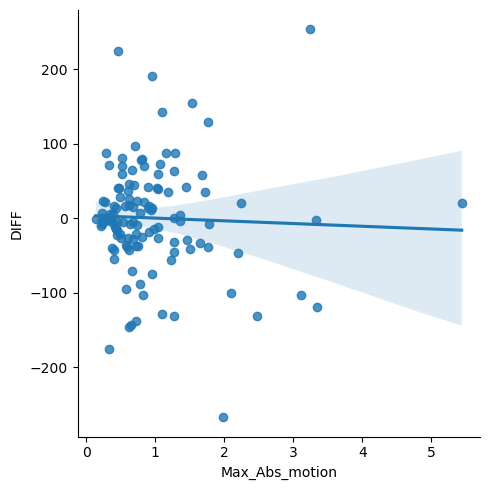

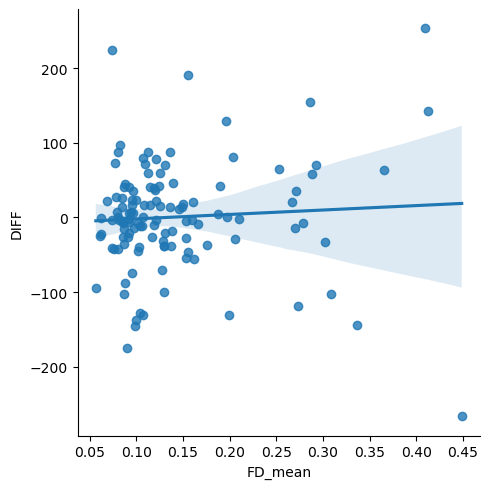

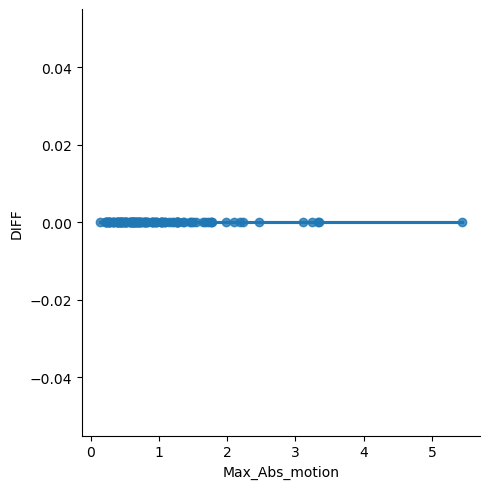

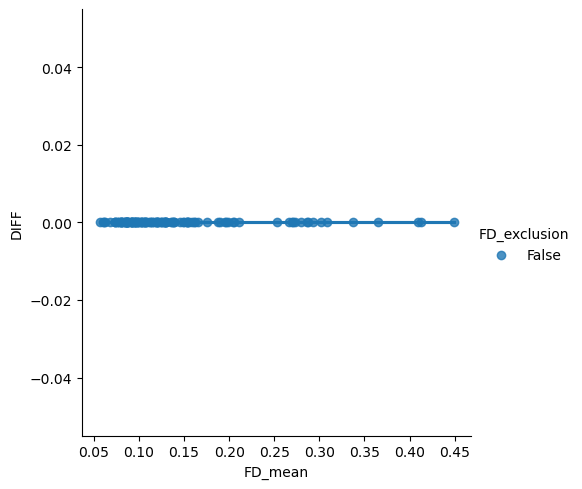

In [9]:
display(plt_df)
from scipy.stats import pearsonr, spearmanr,kendalltau
plt_df=plt_df.dropna()
plt_df['DIFF']=plt_df['VS_Reward_cope']-plt_df['VS_Reward_cope_tedana']
r,p=kendalltau(plt_df['FD_mean'],plt_df['DIFF'])
print(r,p)

sns.lmplot(x='Max_Abs_motion',y='DIFF',data=plt_df)
sns.lmplot(x='FD_mean',y='DIFF',data=plt_df)

plt_df['DIFF']=plt_df['VS_Reward_tstats']-plt_df['VS_Reward_tstat_tedana']
r,p=kendalltau(plt_df['FD_mean'],plt_df['DIFF'])
print(r,p)

sns.lmplot(x='Max_Abs_motion',y='DIFF',data=plt_df)
sns.lmplot(x='FD_mean',y='DIFF',data=plt_df,hue='FD_exclusion')

# FFA-Face Activiation

In [10]:
masker= NiftiMasker(mask_img=FFA_mask)
                   
copes=[]
tstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/cope11.nii.gz'%(sub,aqc)
    tstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/tstat11.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/varcope11.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,tstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(tstat)
        tstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        tstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(FFA_face_cope=copes,
               FFA_face_tstats=tstats,
               FFA_face_varcope=varcopes)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [03:37<00:00,  1.18it/s]


# Display Face Activation by Acquisition (FFA)

HeadNeck_64
z-stat


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        FFA_face_tstats   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.218
Date:                Wed, 02 Aug 2023   Prob (F-statistic):             0.0888
Time:                        15:31:17   Log-Likelihood:                -163.22
No. Observations:                 143   AIC:                             334.4
Df Residuals:                     139   BIC:                             346.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4543      0.241      1.887      0.061      -0.022       0.930
MB             0.0291      0.061      0.476      0.635      -0.092       0.150
ME            -0.0103      0.082     -0.126      0.900      -0.172       0.152
MB:ME          0.0163      0.021      0.781      0.436      -0.025       0.058
==============================================================================
Omnibus:                        0.910   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.635   Jarque-Bera (JB):                0.515
Skew:                          -0.021   Prob(JB):                        0.773
Kurtosis:                       3.291   Cond. No.                         49.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

beta


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          FFA_face_cope   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7617
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.517
Time:                        15:31:17   Log-Likelihood:                -999.30
No. Observations:                 143   AIC:                             2007.
Df Residuals:                     139   BIC:                             2018.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    246.6722     83.318      2.961      0.004      81.937     411.407
MB           -26.1089     21.147     -1.235      0.219     -67.920      15.702
ME           -15.5158     28.382     -0.547      0.585     -71.632      40.600
MB:ME          8.3789      7.224      1.160      0.248      -5.905      22.662
==============================================================================
Omnibus:                        9.163   Durbin-Watson:                   1.680
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               19.901
Skew:                          -0.040   Prob(JB):                     4.77e-05
Kurtosis:                       4.826   Cond. No.                         49.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

HeadNeck_20
z-stat


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        FFA_face_tstats   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.2735
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.844
Time:                        15:31:17   Log-Likelihood:                -96.373
No. Observations:                 104   AIC:                             200.7
Df Residuals:                     100   BIC:                             211.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4104      0.227      1.808      0.074      -0.040       0.861
MB             0.0103      0.057      0.179      0.858      -0.104       0.124
ME             0.0081      0.078      0.103      0.918      -0.147       0.163
MB:ME         -0.0098      0.020     -0.492      0.624      -0.049       0.030
==============================================================================
Omnibus:                        7.694   Durbin-Watson:                   1.527
Prob(Omnibus):                  0.021   Jarque-Bera (JB):               11.911
Skew:                           0.268   Prob(JB):                      0.00259
Kurtosis:                       4.569   Cond. No.                         48.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

beta


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          FFA_face_cope   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.8153
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.488
Time:                        15:31:17   Log-Likelihood:                -719.88
No. Observations:                 104   AIC:                             1448.
Df Residuals:                     100   BIC:                             1458.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    164.2699     91.141      1.802      0.074     -16.551     345.090
MB            -0.7795     23.085     -0.034      0.973     -46.579      45.020
ME            16.0855     31.365      0.513      0.609     -46.142      78.313
MB:ME         -6.1401      7.975     -0.770      0.443     -21.963       9.683
==============================================================================
Omnibus:                        2.410   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.300   Jarque-Bera (JB):                1.813
Skew:                          -0.238   Prob(JB):                        0.404
Kurtosis:                       3.437   Cond. No.                         48.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Results for tstatistics


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        FFA_face_tstats   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     2.516
Date:                Wed, 02 Aug 2023   Prob (F-statistic):             0.0163
Time:                        15:31:17   Log-Likelihood:                -262.29
No. Observations:                 247   AIC:                             540.6
Df Residuals:                     239   BIC:                             568.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.4104      0.259      1.584      0.114      -0.100       0.921
HeadCoil[T.HeadNeck_64]           0.0438      0.342      0.128      0.898      -0.629       0.717
MB                                0.0103      0.066      0.157      0.876      -0.119       0.140
MB:HeadCoil[T.HeadNeck_64]        0.0188      0.087      0.217      0.828      -0.152       0.189
ME                                0.0081      0.089      0.090      0.928      -0.168       0.184
ME:HeadCoil[T.HeadNeck_64]       -0.0184      0.117     -0.157      0.875      -0.249       0.212
MB:ME                            -0.0098      0.023     -0.431      0.667      -0.054       0.035
MB:ME:HeadCoil[T.HeadNeck_64]     0.0261      0.030      0.875      0.382      -0.033       0.085
==============================================================================
Omnibus:                        4.476   Durbin-Watson:                   1.596
Prob(Omnibus):                  0.107   Jarque-Bera (JB):                5.766
Skew:                           0.060   Prob(JB):                       0.0560
Kurtosis:                       3.739   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

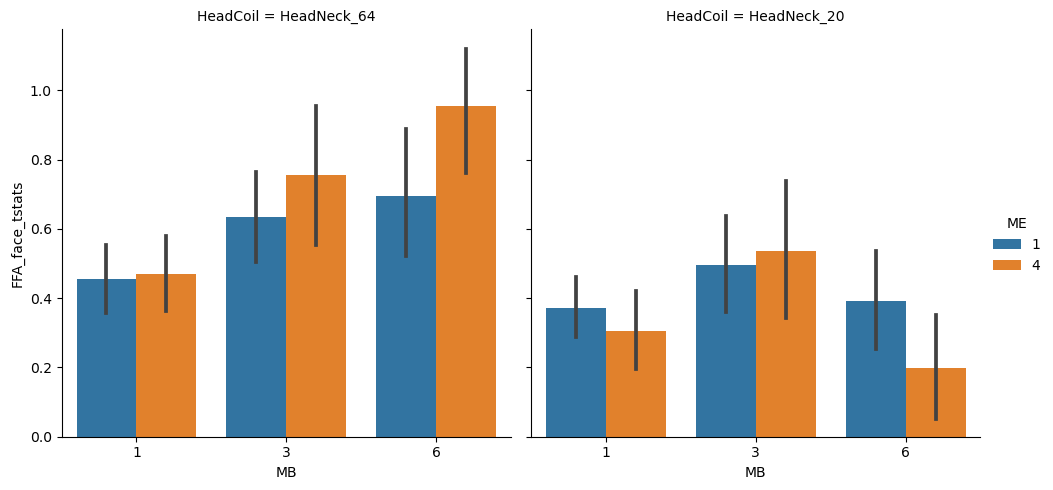

Results for Cope


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          FFA_face_cope   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8704
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.531
Time:                        15:31:19   Log-Likelihood:                -1719.4
No. Observations:                 247   AIC:                             3455.
Df Residuals:                     239   BIC:                             3483.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       164.2699     94.506      1.738      0.083     -21.902     350.441
HeadCoil[T.HeadNeck_64]          82.4023    124.662      0.661      0.509    -163.175     327.980
MB                               -0.7795     23.937     -0.033      0.974     -47.934      46.375
MB:HeadCoil[T.HeadNeck_64]      -25.3294     31.603     -0.801      0.424     -87.585      36.927
ME                               16.0855     32.523      0.495      0.621     -47.984      80.155
ME:HeadCoil[T.HeadNeck_64]      -31.6013     42.717     -0.740      0.460    -115.750      52.548
MB:ME                            -6.1401      8.270     -0.742      0.459     -22.431      10.151
MB:ME:HeadCoil[T.HeadNeck_64]    14.5190     10.866      1.336      0.183      -6.887      35.925
==============================================================================
Omnibus:                        9.997   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               19.198
Skew:                          -0.114   Prob(JB):                     6.78e-05
Kurtosis:                       4.347   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Figure size 640x480 with 0 Axes>

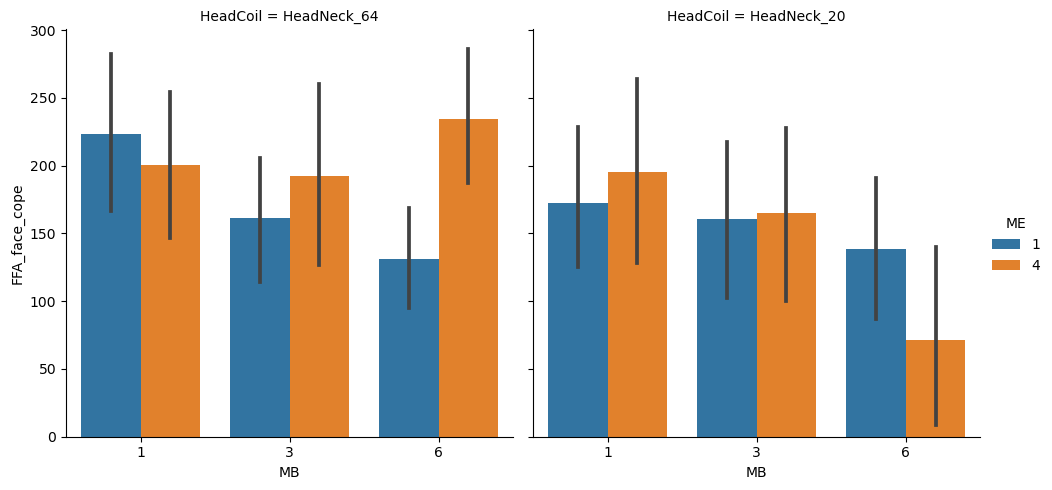

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
import statsmodels.formula.api as smf
plt_df=subs

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.ols('FFA_face_tstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.ols('FFA_face_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for tstatistics")
res=smf.ols('FFA_face_tstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_face_tstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.show()
plt.savefig("../derivatives/figures/assets/FFA_face-act_tstat.svg")

print("Results for Cope")
res=smf.ols('FFA_face_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_face_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/assets/FFA_face-act_cope.svg")


# print("Results for VarCope")
# res=smf.ols('FFA_face_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='FFA_face_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/assets/FFA_face-act_varcope.svg")


# Central Gyrus-Button Activiation

In [12]:
masker= NiftiMasker(mask_img=motor_mask)
                   
copes=[]
tstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/cope12.nii.gz'%(sub,aqc)
    tstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/tstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,tstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(tstat)
        tstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        tstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(Motor_LR_cope=copes,
               Motor_LR_tstats=tstats,
               Motor_LR_varcope=varcopes)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [04:15<00:00,  1.00it/s]


# Display Motor Activation by Acquisition

HeadNeck_64
z-stat


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Motor_LR_tstats   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     3.357
Date:                Wed, 02 Aug 2023   Prob (F-statistic):             0.0207
Time:                        15:35:35   Log-Likelihood:                -172.22
No. Observations:                 143   AIC:                             352.4
Df Residuals:                     139   BIC:                             364.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5465      0.256      2.132      0.035       0.040       1.053
MB             0.1269      0.065      1.951      0.053      -0.002       0.256
ME             0.0270      0.087      0.310      0.757      -0.146       0.200
MB:ME         -0.0087      0.022     -0.393      0.695      -0.053       0.035
==============================================================================
Omnibus:                        1.614   Durbin-Watson:                   1.208
Prob(Omnibus):                  0.446   Jarque-Bera (JB):                1.231
Skew:                           0.052   Prob(JB):                        0.540
Kurtosis:                       3.442   Cond. No.                         49.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

beta


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Motor_LR_cope   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8462
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.471
Time:                        15:35:35   Log-Likelihood:                -967.79
No. Observations:                 143   AIC:                             1944.
Df Residuals:                     139   BIC:                             1955.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    185.4413     66.837      2.775      0.006      53.292     317.591
MB             1.1673     16.964      0.069      0.945     -32.373      34.708
ME            23.7563     22.768      1.043      0.299     -21.260      68.772
MB:ME         -1.6805      5.795     -0.290      0.772     -13.139       9.778
==============================================================================
Omnibus:                        4.850   Durbin-Watson:                   1.223
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                5.922
Skew:                          -0.167   Prob(JB):                       0.0518
Kurtosis:                       3.939   Cond. No.                         49.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

HeadNeck_20
z-stat


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Motor_LR_tstats   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.097
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.354
Time:                        15:35:35   Log-Likelihood:                -113.95
No. Observations:                 104   AIC:                             235.9
Df Residuals:                     100   BIC:                             246.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4680      0.269      1.741      0.085      -0.065       1.001
MB             0.1045      0.068      1.534      0.128      -0.031       0.240
ME             0.1057      0.092      1.142      0.256      -0.078       0.289
MB:ME         -0.0220      0.024     -0.937      0.351      -0.069       0.025
==============================================================================
Omnibus:                       14.136   Durbin-Watson:                   1.552
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.167
Skew:                           0.604   Prob(JB):                     1.54e-05
Kurtosis:                       4.912   Cond. No.                         48.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

beta


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Motor_LR_cope   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.4519
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.717
Time:                        15:35:35   Log-Likelihood:                -729.27
No. Observations:                 104   AIC:                             1467.
Df Residuals:                     100   BIC:                             1477.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    277.0090     99.752      2.777      0.007      79.104     474.914
MB            -7.5669     25.266     -0.299      0.765     -57.694      42.560
ME            14.7575     34.329      0.430      0.668     -53.350      82.865
MB:ME          1.5340      8.729      0.176      0.861     -15.784      18.852
==============================================================================
Omnibus:                       21.689   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.599
Skew:                           0.923   Prob(JB):                     3.07e-08
Kurtosis:                       5.140   Cond. No.                         48.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Results for tstatistics


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Motor_LR_tstats   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2.041
Date:                Wed, 02 Aug 2023   Prob (F-statistic):             0.0508
Time:                        15:35:36   Log-Likelihood:                -286.87
No. Observations:                 247   AIC:                             589.7
Df Residuals:                     239   BIC:                             617.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.4680      0.286      1.636      0.103      -0.096       1.032
HeadCoil[T.HeadNeck_64]           0.0785      0.377      0.208      0.836      -0.665       0.822
MB                                0.1045      0.072      1.441      0.151      -0.038       0.247
MB:HeadCoil[T.HeadNeck_64]        0.0225      0.096      0.235      0.815      -0.166       0.211
ME                                0.1057      0.098      1.073      0.284      -0.088       0.300
ME:HeadCoil[T.HeadNeck_64]       -0.0786      0.129     -0.608      0.544      -0.333       0.176
MB:ME                            -0.0220      0.025     -0.880      0.380      -0.071       0.027
MB:ME:HeadCoil[T.HeadNeck_64]     0.0133      0.033      0.404      0.687      -0.052       0.078
==============================================================================
Omnibus:                        8.612   Durbin-Watson:                   1.335
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               11.840
Skew:                           0.243   Prob(JB):                      0.00269
Kurtosis:                       3.956   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

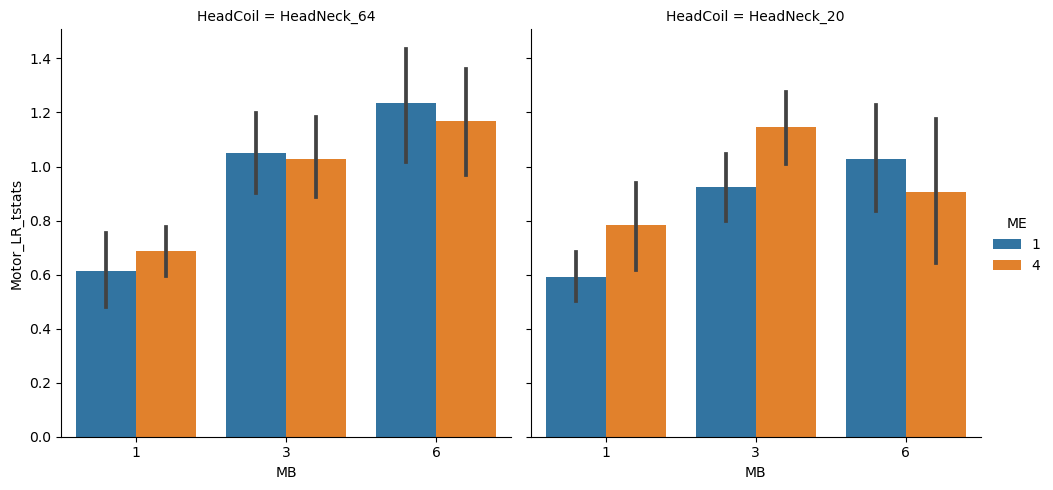

Results for Cope


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Motor_LR_cope   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.181
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.314
Time:                        15:35:36   Log-Likelihood:                -1700.7
No. Observations:                 247   AIC:                             3417.
Df Residuals:                     239   BIC:                             3445.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       277.0090     87.603      3.162      0.002     104.436     449.582
HeadCoil[T.HeadNeck_64]         -91.5677    115.557     -0.792      0.429    -319.207     136.072
MB                               -7.5669     22.189     -0.341      0.733     -51.277      36.144
MB:HeadCoil[T.HeadNeck_64]        8.7342     29.295      0.298      0.766     -48.974      66.443
ME                               14.7575     30.148      0.490      0.625     -44.632      74.147
ME:HeadCoil[T.HeadNeck_64]        8.9989     39.596      0.227      0.820     -69.004      87.002
MB:ME                             1.5340      7.666      0.200      0.842     -13.567      16.635
MB:ME:HeadCoil[T.HeadNeck_64]    -3.2145     10.073     -0.319      0.750     -23.057      16.628
==============================================================================
Omnibus:                       24.874   Durbin-Watson:                   1.506
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.166
Skew:                           0.500   Prob(JB):                     4.70e-12
Kurtosis:                       5.017   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

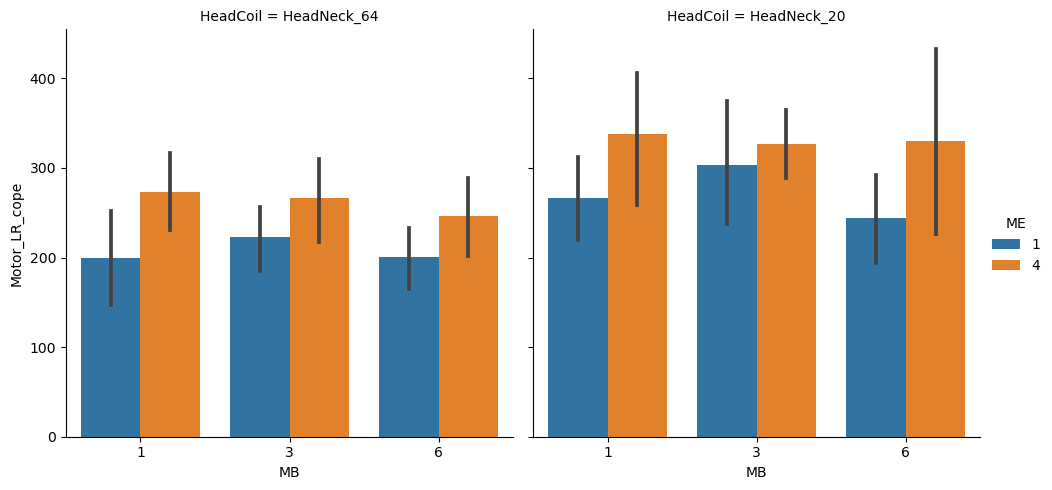

In [13]:
import statsmodels.formula.api as smf
plt_df=subs

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.ols('Motor_LR_tstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.ols('Motor_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for tstatistics")
res=smf.ols('Motor_LR_tstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_tstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.savefig("../derivatives/figures/assets/Motor_LR-act_tstat.svg")
plt.show()

print("Results for Cope")
res=smf.ols('Motor_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/Motor_LR-act_cope.svg")
plt.show()


# print("Results for VarCope")
# res=smf.ols('Motor_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='Motor_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])

#plt.savefig("../derivatives/figures/assets/Motor_LR-act_varcope.svg")
#plt.show()

# Central ICerbt-Button Activiation

In [14]:
masker= NiftiMasker(mask_img=iCerb_mask)
                   
copes=[]
tstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/cope12.nii.gz'%(sub,aqc)
    tstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/tstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,tstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(tstat)
        tstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        tstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(iCerb_LR_cope=copes,
               iCerb_LR_tstats=tstats,
               iCerb_LR_varcope=varcopes)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [03:28<00:00,  1.23it/s]


# Display Inferior Cerebellar Activation by Acquisition

HeadNeck_64
z-stat


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        iCerb_LR_tstats   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     4.546
Date:                Wed, 02 Aug 2023   Prob (F-statistic):             0.0367
Time:                        15:39:06   Log-Likelihood:                -56.434
No. Observations:                  69   AIC:                             116.9
Df Residuals:                      67   BIC:                             121.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0230      0.008      3.058      0.003       0.008       0.038
MB             0.0041      0.002      2.132      0.037       0.000       0.008
ME             0.0918      0.030      3.058      0.003       0.032       0.152
MB:ME          0.0164      0.008      2.132      0.037       0.001       0.032
==============================================================================
Omnibus:                       18.836   Durbin-Watson:                   1.577
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.809
Skew:                          -1.110   Prob(JB):                     2.49e-06
Kurtosis:                       5.013   Cond. No.                     1.52e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.13e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

beta


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          iCerb_LR_cope   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.2497
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.619
Time:                        15:39:06   Log-Likelihood:                -475.66
No. Observations:                  69   AIC:                             955.3
Df Residuals:                      67   BIC:                             959.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.7274      3.267      2.977      0.004       3.206      16.249
MB             0.4170      0.834      0.500      0.619      -1.248       2.082
ME            38.9097     13.069      2.977      0.004      12.824      64.995
MB:ME          1.6679      3.337      0.500      0.619      -4.994       8.329
==============================================================================
Omnibus:                       41.694   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.580
Skew:                          -1.661   Prob(JB):                     1.37e-40
Kurtosis:                      10.267   Cond. No.                     1.52e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.13e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

HeadNeck_20
z-stat


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        iCerb_LR_tstats   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.1666
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.685
Time:                        15:39:06   Log-Likelihood:                -42.655
No. Observations:                  51   AIC:                             89.31
Df Residuals:                      49   BIC:                             93.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0221      0.009      2.468      0.017       0.004       0.040
MB             0.0009      0.002      0.408      0.685      -0.004       0.006
ME             0.0883      0.036      2.468      0.017       0.016       0.160
MB:ME          0.0037      0.009      0.408      0.685      -0.015       0.022
==============================================================================
Omnibus:                        1.117   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.572   Jarque-Bera (JB):                1.019
Skew:                           0.331   Prob(JB):                        0.601
Kurtosis:                       2.797   Cond. No.                     5.77e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.19e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

beta


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          iCerb_LR_cope   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.4128
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.524
Time:                        15:39:06   Log-Likelihood:                -353.32
No. Observations:                  51   AIC:                             710.6
Df Residuals:                      49   BIC:                             714.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.9369      3.953      2.008      0.050      -0.008      15.882
MB             0.6487      1.010      0.643      0.524      -1.380       2.678
ME            31.7478     15.814      2.008      0.050      -0.031      63.526
MB:ME          2.5947      4.038      0.643      0.524      -5.521      10.710
==============================================================================
Omnibus:                        2.199   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.333   Jarque-Bera (JB):                2.094
Skew:                           0.469   Prob(JB):                        0.351
Kurtosis:                       2.673   Cond. No.                     5.77e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.19e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Results for tstatistics


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        iCerb_LR_tstats   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     2.706
Date:                Wed, 02 Aug 2023   Prob (F-statistic):             0.0485
Time:                        15:39:06   Log-Likelihood:                -99.099
No. Observations:                 120   AIC:                             206.2
Df Residuals:                     116   BIC:                             217.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0221      0.009      2.501      0.014       0.005       0.040
HeadCoil[T.HeadNeck_64]           0.0009      0.012      0.077      0.939      -0.022       0.024
MB                                0.0009      0.002      0.414      0.680      -0.004       0.005
MB:HeadCoil[T.HeadNeck_64]        0.0032      0.003      1.062      0.290      -0.003       0.009
ME                                0.0883      0.035      2.501      0.014       0.018       0.158
ME:HeadCoil[T.HeadNeck_64]        0.0036      0.047      0.077      0.939      -0.089       0.096
MB:ME                             0.0037      0.009      0.414      0.680      -0.014       0.022
MB:ME:HeadCoil[T.HeadNeck_64]     0.0126      0.012      1.062      0.290      -0.011       0.036
==============================================================================
Omnibus:                        8.845   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                9.894
Skew:                          -0.478   Prob(JB):                      0.00710
Kurtosis:                       4.032   Cond. No.                     1.09e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.87e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

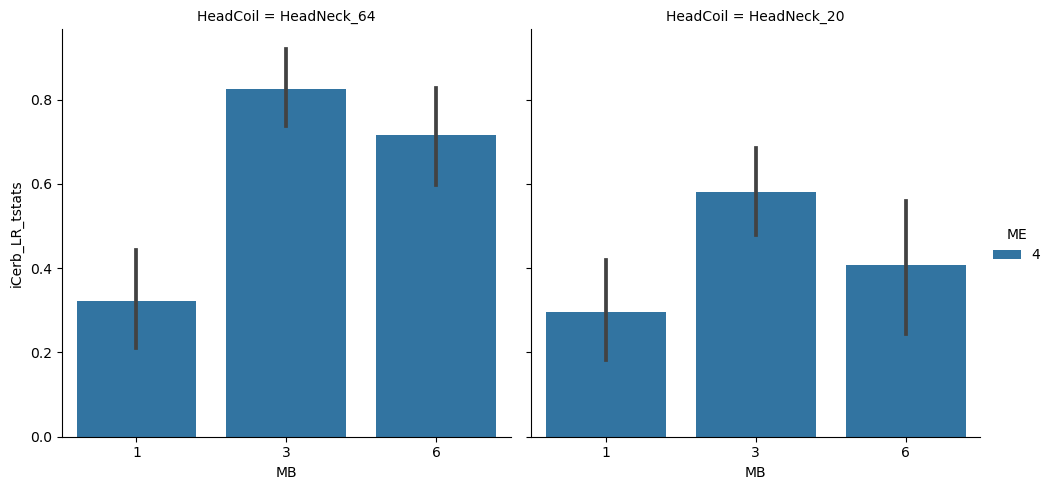

Results for Cope


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          iCerb_LR_cope   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.2727
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.845
Time:                        15:39:06   Log-Likelihood:                -829.01
No. Observations:                 120   AIC:                             1666.
Df Residuals:                     116   BIC:                             1677.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         7.9369      3.866      2.053      0.042       0.281      15.593
HeadCoil[T.HeadNeck_64]           1.7905      5.098      0.351      0.726      -8.307      11.887
MB                                0.6487      0.987      0.657      0.512      -1.307       2.604
MB:HeadCoil[T.HeadNeck_64]       -0.2317      1.302     -0.178      0.859      -2.810       2.347
ME                               31.7478     15.463      2.053      0.042       1.122      62.374
ME:HeadCoil[T.HeadNeck_64]        7.1619     20.392      0.351      0.726     -33.226      47.550
MB:ME                             2.5947      3.949      0.657      0.512      -5.226      10.416
MB:ME:HeadCoil[T.HeadNeck_64]    -0.9269      5.208     -0.178      0.859     -11.241       9.387
==============================================================================
Omnibus:                       25.978   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.744
Skew:                          -0.703   Prob(JB):                     1.78e-18
Kurtosis:                       6.791   Cond. No.                     1.09e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.87e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

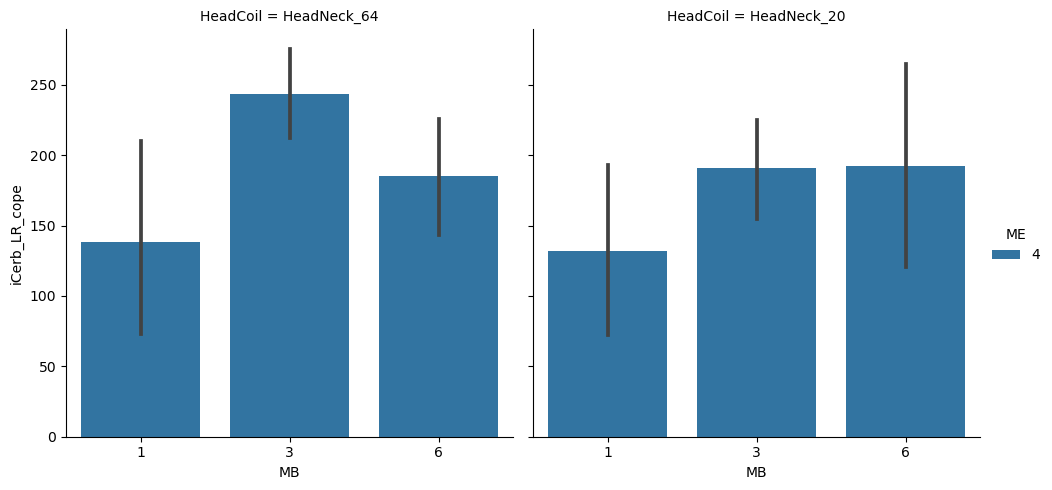

<Figure size 640x480 with 0 Axes>

In [15]:
import statsmodels.formula.api as smf
plt_df=subs.dropna()
for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.ols('iCerb_LR_tstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.ols('iCerb_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for tstatistics")
res=smf.ols('iCerb_LR_tstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='iCerb_LR_tstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.savefig("../derivatives/figures/assets/iCerb_LR-act_tstat.svg")
plt.show()

print("Results for Cope")
res=smf.ols('iCerb_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='iCerb_LR_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/iCerb_LR-act_cope.svg")
plt.show()

# print("Results for VarCope")
# res=smf.ols('iCerb_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='iCerb_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/iCerb_LR-act_varcope.svg")
plt.show()

# SCerb-Button Activiation

In [16]:
masker= NiftiMasker(mask_img=sCerb_mask)
                   
copes=[]
tstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/cope12.nii.gz'%(sub,aqc)
    tstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/tstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,tstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(tstat)
        tstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        tstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(SCerb_LR_cope=copes,
               SCerb_LR_tstats=tstats,
               SCerb_LR_varcope=varcopes)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [03:36<00:00,  1.18it/s]


# Display Superior Cerebellar Activation by Acquisition

HeadNeck_64
z-stat


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        SCerb_LR_tstats   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     3.715
Date:                Wed, 02 Aug 2023   Prob (F-statistic):             0.0582
Time:                        15:42:44   Log-Likelihood:                -58.062
No. Observations:                  69   AIC:                             120.1
Df Residuals:                      67   BIC:                             124.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0328      0.008      4.272      0.000       0.017       0.048
MB             0.0038      0.002      1.928      0.058      -0.000       0.008
ME             0.1314      0.031      4.272      0.000       0.070       0.193
MB:ME          0.0151      0.008      1.928      0.058      -0.001       0.031
==============================================================================
Omnibus:                        9.967   Durbin-Watson:                   1.289
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.816
Skew:                          -0.796   Prob(JB):                      0.00739
Kurtosis:                       3.938   Cond. No.                     1.52e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.13e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

beta


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SCerb_LR_cope   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                 0.0001503
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.990
Time:                        15:42:44   Log-Likelihood:                -485.19
No. Observations:                  69   AIC:                             974.4
Df Residuals:                      67   BIC:                             978.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.2924      3.751      4.343      0.000       8.805      23.780
MB             0.0117      0.958      0.012      0.990      -1.900       1.924
ME            65.1695     15.005      4.343      0.000      35.220      95.119
MB:ME          0.0470      3.832      0.012      0.990      -7.601       7.695
==============================================================================
Omnibus:                       15.424   Durbin-Watson:                   1.206
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.906
Skew:                          -0.691   Prob(JB):                     1.94e-07
Kurtosis:                       5.973   Cond. No.                     1.52e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.13e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

HeadNeck_20
z-stat


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        SCerb_LR_tstats   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.3071
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.582
Time:                        15:42:44   Log-Likelihood:                -37.908
No. Observations:                  51   AIC:                             79.82
Df Residuals:                      49   BIC:                             83.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0282      0.008      3.458      0.001       0.012       0.045
MB             0.0012      0.002      0.554      0.582      -0.003       0.005
ME             0.1127      0.033      3.458      0.001       0.047       0.178
MB:ME          0.0046      0.008      0.554      0.582      -0.012       0.021
==============================================================================
Omnibus:                        1.176   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.556   Jarque-Bera (JB):                0.619
Skew:                           0.251   Prob(JB):                        0.734
Kurtosis:                       3.197   Cond. No.                     5.77e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.19e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

beta


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SCerb_LR_cope   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7357
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.395
Time:                        15:42:44   Log-Likelihood:                -353.56
No. Observations:                  51   AIC:                             711.1
Df Residuals:                      49   BIC:                             715.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.8469      3.972      2.479      0.017       1.865      17.829
MB             0.8700      1.014      0.858      0.395      -1.168       2.908
ME            39.3875     15.887      2.479      0.017       7.461      71.315
MB:ME          3.4801      4.057      0.858      0.395      -4.673      11.634
==============================================================================
Omnibus:                        6.173   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                6.226
Skew:                          -0.455   Prob(JB):                       0.0445
Kurtosis:                       4.449   Cond. No.                     5.77e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.19e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Results for tstatistics


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        SCerb_LR_tstats   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     3.118
Date:                Wed, 02 Aug 2023   Prob (F-statistic):             0.0288
Time:                        15:42:44   Log-Likelihood:                -96.249
No. Observations:                 120   AIC:                             200.5
Df Residuals:                     116   BIC:                             211.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0282      0.009      3.270      0.001       0.011       0.045
HeadCoil[T.HeadNeck_64]           0.0047      0.011      0.411      0.682      -0.018       0.027
MB                                0.0012      0.002      0.524      0.601      -0.003       0.006
MB:HeadCoil[T.HeadNeck_64]        0.0026      0.003      0.907      0.366      -0.003       0.008
ME                                0.1127      0.034      3.270      0.001       0.044       0.181
ME:HeadCoil[T.HeadNeck_64]        0.0187      0.045      0.411      0.682      -0.071       0.109
MB:ME                             0.0046      0.009      0.524      0.601      -0.013       0.022
MB:ME:HeadCoil[T.HeadNeck_64]     0.0105      0.012      0.907      0.366      -0.012       0.034
==============================================================================
Omnibus:                        6.441   Durbin-Watson:                   1.568
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                6.249
Skew:                          -0.426   Prob(JB):                       0.0440
Kurtosis:                       3.725   Cond. No.                     1.09e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.87e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

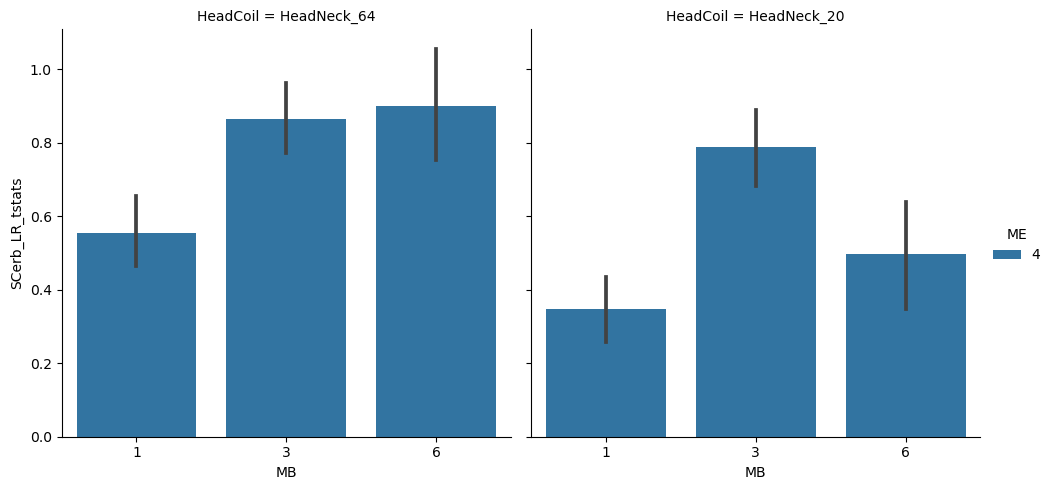

Results for Cope


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SCerb_LR_cope   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.7256
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.539
Time:                        15:42:45   Log-Likelihood:                -839.03
No. Observations:                 120   AIC:                             1686.
Df Residuals:                     116   BIC:                             1697.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         9.8469      4.202      2.343      0.021       1.524      18.170
HeadCoil[T.HeadNeck_64]           6.4455      5.542      1.163      0.247      -4.531      17.422
MB                                0.8700      1.073      0.811      0.419      -1.256       2.996
MB:HeadCoil[T.HeadNeck_64]       -0.8583      1.415     -0.606      0.545      -3.661       1.945
ME                               39.3875     16.809      2.343      0.021       6.095      72.680
ME:HeadCoil[T.HeadNeck_64]       25.7819     22.167      1.163      0.247     -18.124      69.687
MB:ME                             3.4801      4.293      0.811      0.419      -5.022      11.982
MB:ME:HeadCoil[T.HeadNeck_64]    -3.4332      5.661     -0.606      0.545     -14.646       7.779
==============================================================================
Omnibus:                       18.655   Durbin-Watson:                   1.473
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.138
Skew:                          -0.610   Prob(JB):                     3.17e-09
Kurtosis:                       5.518   Cond. No.                     1.09e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.87e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

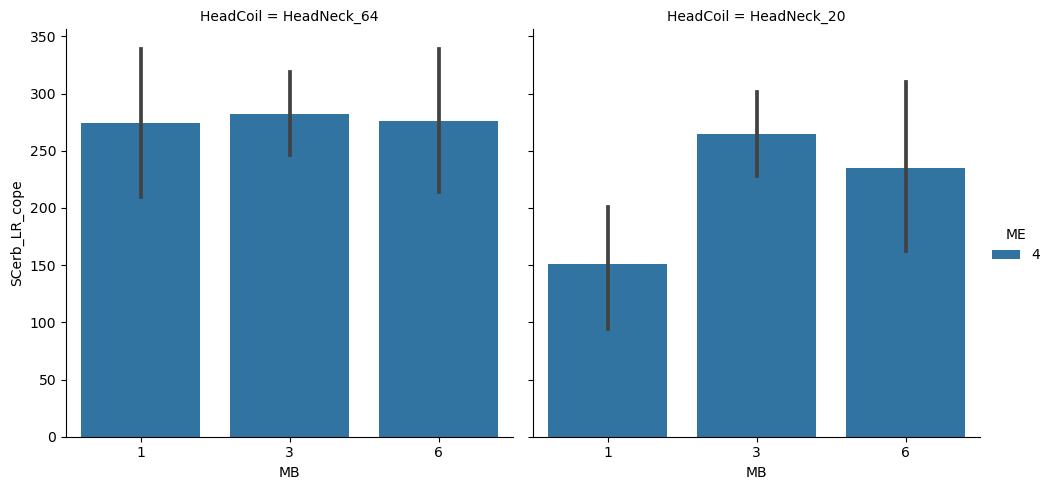

In [17]:
import statsmodels.formula.api as smf
plt_df=subs.dropna()

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.ols('SCerb_LR_tstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.ols('SCerb_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for tstatistics")
res=smf.ols('SCerb_LR_tstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='SCerb_LR_tstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.savefig("../derivatives/figures/assets/sCerb_LR-act_tstat.svg")
plt.show()

print("Results for Cope")
res=smf.ols('SCerb_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='SCerb_LR_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/sCerb_LR-act_cope.svg")
plt.show()

# print("Results for VarCope")
# res=smf.ols('SCerb_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='SCerb_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])

#plt.savefig("../derivatives/figures/assets/sCerb_LR-act_varcope.svg")
#plt.show()

# vmPFC

In [18]:
masker= NiftiMasker(mask_img=pfc_mask)
                   
copes=[]
tstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/cope13.nii.gz'%(sub,aqc)
    tstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/tstat13.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/varcope13.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,tstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(tstat)
        tstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        tstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(pfc_act_cope=copes,
               pfc_act_tstats=tstats,
               pfc_act_varcope=varcopes)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [03:49<00:00,  1.12it/s]


# Display vmPFC

HeadNeck_64
z-stat


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         pfc_act_tstats   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     4.625
Date:                Wed, 02 Aug 2023   Prob (F-statistic):             0.0351
Time:                        15:46:35   Log-Likelihood:                -69.558
No. Observations:                  69   AIC:                             143.1
Df Residuals:                      67   BIC:                             147.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0043      0.009      0.474      0.637      -0.014       0.022
MB             0.0050      0.002      2.151      0.035       0.000       0.010
ME             0.0172      0.036      0.474      0.637      -0.055       0.090
MB:ME          0.0199      0.009      2.151      0.035       0.001       0.038
==============================================================================
Omnibus:                        2.074   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.355   Jarque-Bera (JB):                1.445
Skew:                          -0.096   Prob(JB):                        0.486
Kurtosis:                       3.683   Cond. No.                     1.52e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.13e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

beta


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           pfc_act_cope   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.034
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.158
Time:                        15:46:35   Log-Likelihood:                -463.87
No. Observations:                  69   AIC:                             931.7
Df Residuals:                      67   BIC:                             936.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0291      2.754      0.374      0.710      -4.468       6.527
MB             1.0031      0.703      1.426      0.158      -0.401       2.407
ME             4.1162     11.017      0.374      0.710     -17.874      26.106
MB:ME          4.0125      2.814      1.426      0.158      -1.603       9.628
==============================================================================
Omnibus:                        2.114   Durbin-Watson:                   2.448
Prob(Omnibus):                  0.348   Jarque-Bera (JB):                1.529
Skew:                          -0.352   Prob(JB):                        0.466
Kurtosis:                       3.190   Cond. No.                     1.52e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.13e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

HeadNeck_20
z-stat


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         pfc_act_tstats   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.1813
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.672
Time:                        15:46:35   Log-Likelihood:                -46.561
No. Observations:                  51   AIC:                             97.12
Df Residuals:                      49   BIC:                             101.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0166      0.010      1.718      0.092      -0.003       0.036
MB            -0.0010      0.002     -0.426      0.672      -0.006       0.004
ME             0.0664      0.039      1.718      0.092      -0.011       0.144
MB:ME         -0.0042      0.010     -0.426      0.672      -0.024       0.016
==============================================================================
Omnibus:                        4.949   Durbin-Watson:                   1.578
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                3.841
Skew:                           0.610   Prob(JB):                        0.147
Kurtosis:                       3.563   Cond. No.                     5.77e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.19e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

beta


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           pfc_act_cope   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.128
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.294
Time:                        15:46:35   Log-Likelihood:                -343.39
No. Observations:                  51   AIC:                             690.8
Df Residuals:                      49   BIC:                             694.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.8092      3.254      2.400      0.020       1.270      14.348
MB            -0.8824      0.831     -1.062      0.294      -2.552       0.788
ME            31.2367     13.016      2.400      0.020       5.081      57.392
MB:ME         -3.5295      3.324     -1.062      0.294     -10.209       3.150
==============================================================================
Omnibus:                        1.451   Durbin-Watson:                   1.373
Prob(Omnibus):                  0.484   Jarque-Bera (JB):                1.307
Skew:                           0.244   Prob(JB):                        0.520
Kurtosis:                       2.386   Cond. No.                     5.77e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.19e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Results for tstatistics


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         pfc_act_tstats   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     2.123
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.101
Time:                        15:46:35   Log-Likelihood:                -116.38
No. Observations:                 120   AIC:                             240.8
Df Residuals:                     116   BIC:                             251.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0166      0.010      1.628      0.106      -0.004       0.037
HeadCoil[T.HeadNeck_64]          -0.0123      0.013     -0.914      0.362      -0.039       0.014
MB                               -0.0010      0.003     -0.403      0.687      -0.006       0.004
MB:HeadCoil[T.HeadNeck_64]        0.0060      0.003      1.759      0.081      -0.001       0.013
ME                                0.0664      0.041      1.628      0.106      -0.014       0.147
ME:HeadCoil[T.HeadNeck_64]       -0.0491      0.054     -0.914      0.362      -0.156       0.057
MB:ME                            -0.0042      0.010     -0.403      0.687      -0.025       0.016
MB:ME:HeadCoil[T.HeadNeck_64]     0.0241      0.014      1.759      0.081      -0.003       0.051
==============================================================================
Omnibus:                        2.987   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.225   Jarque-Bera (JB):                2.763
Skew:                           0.157   Prob(JB):                        0.251
Kurtosis:                       3.674   Cond. No.                     1.09e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.87e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

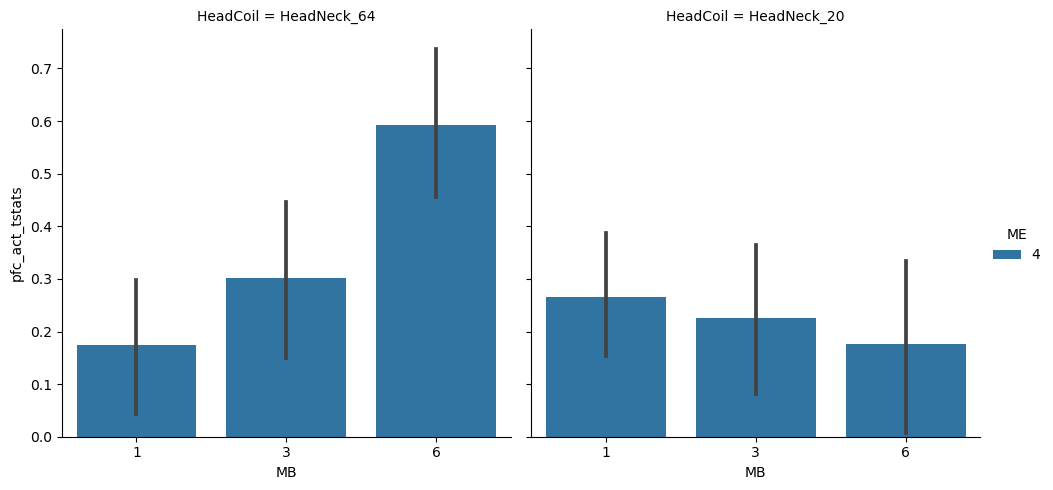

Results for Cope


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           pfc_act_cope   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.068
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.366
Time:                        15:46:36   Log-Likelihood:                -807.26
No. Observations:                 120   AIC:                             1623.
Df Residuals:                     116   BIC:                             1634.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         7.8092      3.225      2.421      0.017       1.422      14.197
HeadCoil[T.HeadNeck_64]          -6.7801      4.253     -1.594      0.114     -15.204       1.643
MB                               -0.8824      0.824     -1.071      0.286      -2.514       0.749
MB:HeadCoil[T.HeadNeck_64]        1.8855      1.086      1.736      0.085      -0.266       4.037
ME                               31.2367     12.900      2.421      0.017       5.687      56.787
ME:HeadCoil[T.HeadNeck_64]      -27.1205     17.012     -1.594      0.114     -60.815       6.574
MB:ME                            -3.5295      3.294     -1.071      0.286     -10.054       2.995
MB:ME:HeadCoil[T.HeadNeck_64]     7.5420      4.344      1.736      0.085      -1.063      16.147
==============================================================================
Omnibus:                        0.208   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.901   Jarque-Bera (JB):                0.304
Skew:                          -0.094   Prob(JB):                        0.859
Kurtosis:                       2.841   Cond. No.                     1.09e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.87e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<Figure size 640x480 with 0 Axes>

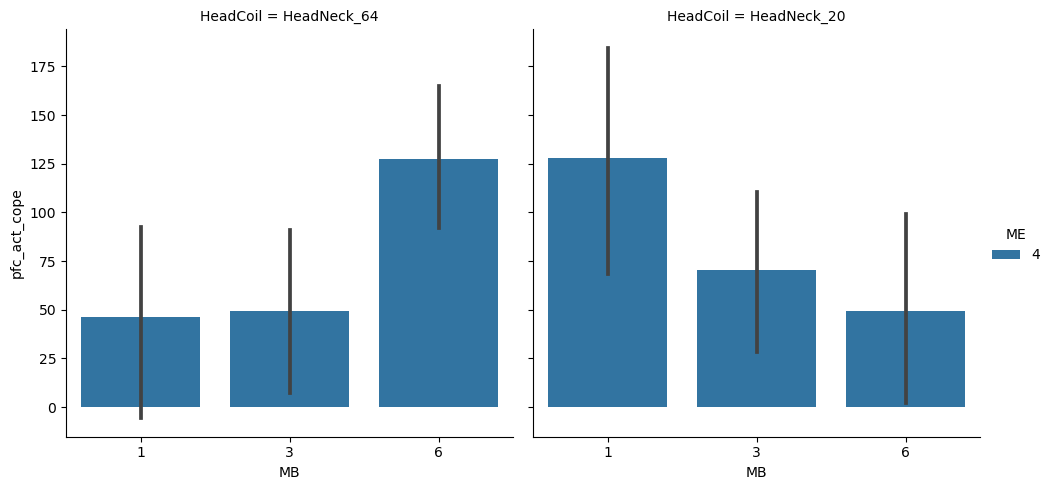

<Figure size 640x480 with 0 Axes>

In [19]:
import statsmodels.formula.api as smf
plt_df=subs.dropna()

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.ols('pfc_act_tstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.ols('pfc_act_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for tstatistics")
res=smf.ols('pfc_act_tstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='pfc_act_tstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.show()
plt.savefig("../derivatives/figures/assets/pfc_act-act_tstat.svg")

print("Results for Cope")
res=smf.ols('pfc_act_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='pfc_act_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/assets/pfc_act-act_cope.svg")


# print("Results for VarCope")
# res=smf.ols('pfc_act_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='pfc_act_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
#plt.show()
#plt.savefig("../derivatives/figures/assets/pfc_act-act_varcope.svg")